In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

data_path = os.path.join(os.getcwd())

In [5]:
# get top 50 stocks by market cap
top_stocks = pd.read_csv(os.path.join(data_path, 'top50stocks.csv'))
top_stocks.head()

,rank,name,symbol,market_cap
0,1,APPLE INC.,AAPL,2525.11
1,2,MICROSOFT CORPORATION,MSFT,2099.65
2,3,ALPHABET INC.,GOOG,1724.81
3,4,"AMAZON.COM, INC.",AMZN,1480.99
4,5,"TESLA, INC.",TSLA,822.00


In [6]:
from sklearn.preprocessing import MinMaxScaler

def get_stock_data(symbol, folder='Stocks'):
    """
    Gets stock data from Kaggle files
    """
    df = pd.read_csv(os.path.join(data_path, folder, f"{symbol}.us.txt"), index_col="Date", parse_dates=True)
    return df

transformers = {}

def get_scaled_stock_data(symbol, folder='Stocks'):
    """
    Gets scaled data from from a symbol
    """

    df = get_stock_data(symbol, folder)

    scaler = MinMaxScaler(feature_range=(0, 1))
    if 'OpenInt' in df.columns:
        df = df.drop('OpenInt', axis=1)
    scaled_data = scaler.fit_transform(df)

    cols = ['Open', 'High', 'Low', 'Close', 'Volume']

    return scaler, scaled_data, cols


In [7]:
#import train test split
from sklearn.model_selection import train_test_split

def get_model_data(symbol, folder='Stocks'):
    """
    Gets scaled data from from a symbol
    """

    scaler, scaled_data, cols = get_scaled_stock_data(symbol, folder=folder)

    diff = 30
    pred_diff = 1

    X = []
    y = []

    # get train test split
    for i in range(diff, len(scaled_data) - pred_diff):
        # print("Getting x and y")
        # print(f"x = [{i - diff}:{i}]")
        # print(f"y = [{i}:{i + pred_diff}]")
        X.append(scaled_data[i - diff:i].reshape(1, diff, 5))
        y.append(scaled_data[i:i+pred_diff].reshape(1, 5))

    # don't shuffle to train on historical data
    return train_test_split(X, y, test_size=0.3)

# Get the model data
X_train, X_test, y_train, y_test = get_model_data('aapl')
# X_train[0][0]

**Source**: A lot of this code comes from https://www.tensorflow.org/tutorials/structured_data/time_series

In [34]:
scaler, scaled_data, cols = get_scaled_stock_data('aapl')
df = pd.DataFrame(scaled_data, columns=cols)
train, val, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train, val_df=val, test_df=test,
               label_columns=['Open', 'High', 'Low', 'Close', 'Volume']):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

![Visualizing Example from below](images/Example1Generator.jpg)


In [35]:
# Example 1 from slide
window_generator = WindowGenerator(
                        input_width=6,
                        label_width=1,
                        shift=1)

In [36]:
generator = WindowGenerator(input_width=48, label_width=1, shift=1)
generator

Total window size: 49
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48]
Label column name(s): ['Open', 'High', 'Low', 'Close', 'Volume']

## Split Window

![Visualizing Example from below](images/Spliting.jpg)

In [37]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [38]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train[:generator.total_window_size]),
                           np.array(train[100:100+generator.total_window_size]),
                           np.array(train[200:200+generator.total_window_size]),
                           np.array(train[300:300+generator.total_window_size]),
                           np.array(train[400:400+generator.total_window_size]),
                           np.array(train[500:500+generator.total_window_size]),])

example_inputs, example_labels = generator.split_window(example_window)

generator.example = example_inputs, example_labels

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (6, 49, 5)
Inputs shape: (6, 48, 5)
Labels shape: (6, 1, 5)


**Notes**: (_, _, 5) -> The final dimension represents the [Open, High, Low, Close, Volume] dimension

In [39]:
generator.example = example_inputs, example_labels

def plot(self, model=None, plot_col='Close', max_subplots=6):
  inputs, labels = self.example
  plt.figure(figsize=(16, 12))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      # print(predictions.shape)
      # print(len(predictions.shape))
      if (len(predictions.shape) == 3):
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)
      else:
        plt.scatter(self.label_indices, predictions[n, label_col_index],
            marker='X', edgecolors='k', label='Predictions',
            c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

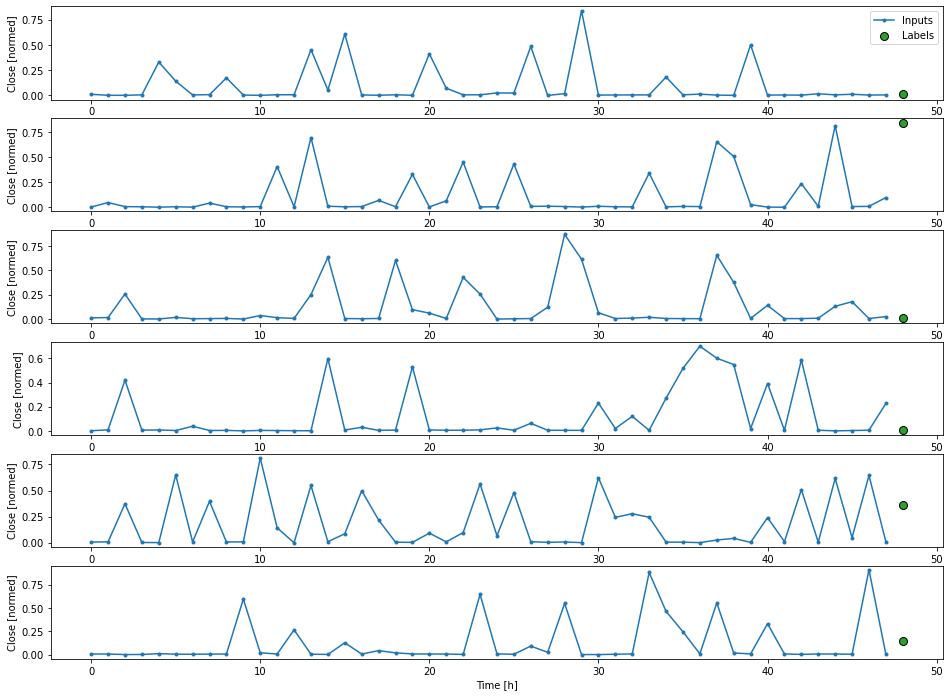

In [40]:
generator.plot(plot_col='Close')

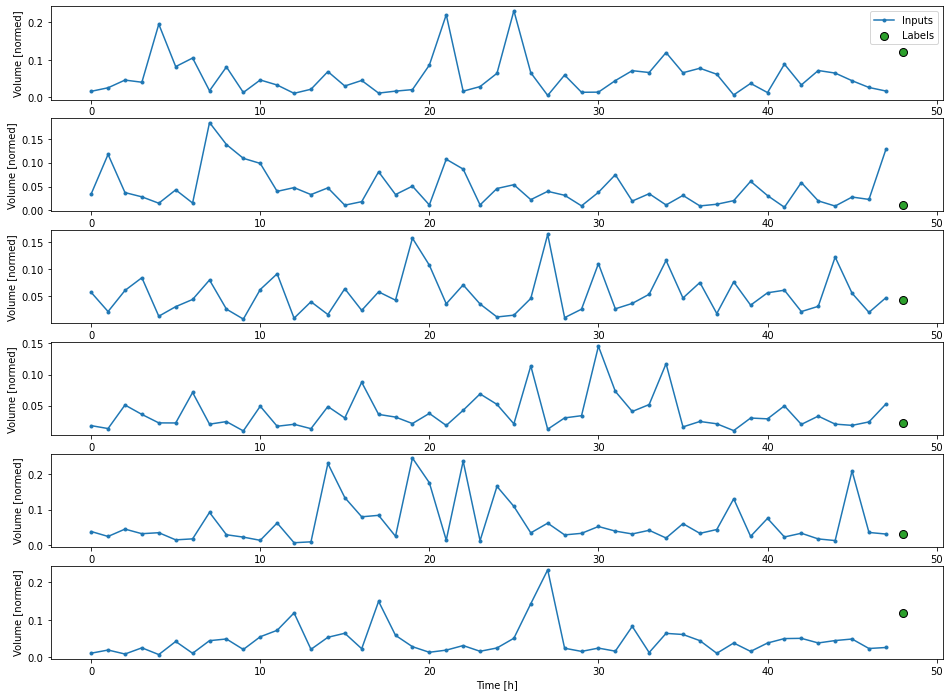

In [51]:
generator.plot(plot_col='Volume')

In [252]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=256,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [253]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test

In [254]:
# generator = WindowGenerator(input_width=24, label_width=1, shift=1)
# generator

In [255]:
def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy',
                                            patience=patience,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.0000001)

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanAbsolutePercentageError()])

  history = model.fit(window.train, epochs=20,
                      validation_data=window.val,
                      callbacks=[early_stopping, learning_rate_reduction])
  return history

## Mean Absolute Percentage Error

`loss = 100 * mean(abs((y_true - y_pred) / y_true), axis=-1)`

# Dense Layers

In [256]:
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Reshape([1, -1])
])

compile_and_fit(model_1, generator)

Epoch 1/20
20/20 [==============================] - 1s 14ms/step - loss: 0.0618 - mean_absolute_error: 0.1793 - mean_absolute_percentage_error: 3670.7666 - val_loss: 0.0451 - val_mean_absolute_error: 0.1475 - val_mean_absolute_percentage_error: 56193.4258 - lr: 0.0010
Epoch 2/20
20/20 [==============================] - 0s 9ms/step - loss: 0.0444 - mean_absolute_error: 0.1506 - mean_absolute_percentage_error: 3255.8757 - val_loss: 0.0429 - val_mean_absolute_error: 0.1417 - val_mean_absolute_percentage_error: 35701.4180 - lr: 0.0010
Epoch 3/20
20/20 [==============================] - 0s 7ms/step - loss: 0.0419 - mean_absolute_error: 0.1439 - mean_absolute_percentage_error: 3029.6106 - val_loss: 0.0419 - val_mean_absolute_error: 0.1461 - val_mean_absolute_percentage_error: 44976.9766 - lr: 0.0010
Epoch 4/20
20/20 [==============================] - 0s 7ms/step - loss: 0.0404 - mean_absolute_error: 0.1410 - mean_absolute_percentage_error: 3004.1531 - val_loss: 0.0414 - val_mean_absolute_err

In [257]:
model_1.summary()

Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_19 (Flatten)        (None, 240)               0         
                                                                 
 dense_143 (Dense)           (None, 128)               30848     
                                                                 
 dense_144 (Dense)           (None, 5)                 645       
                                                                 
 reshape_47 (Reshape)        (None, 1, 5)              0         
                                                                 
Total params: 31,493
Trainable params: 31,493
Non-trainable params: 0
_________________________________________________________________


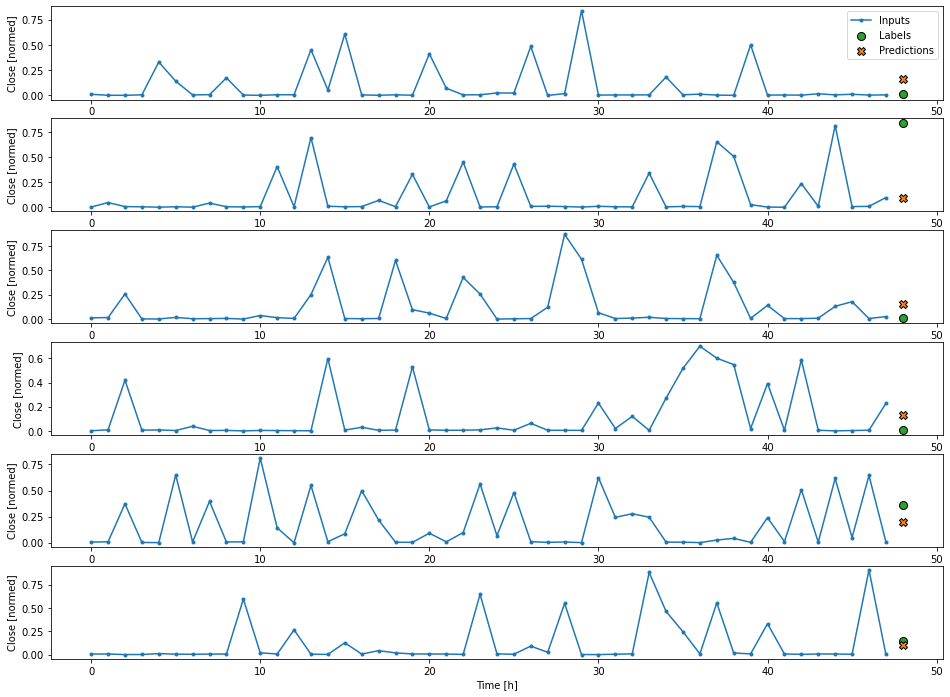

In [258]:
generator.plot(model=model_1)

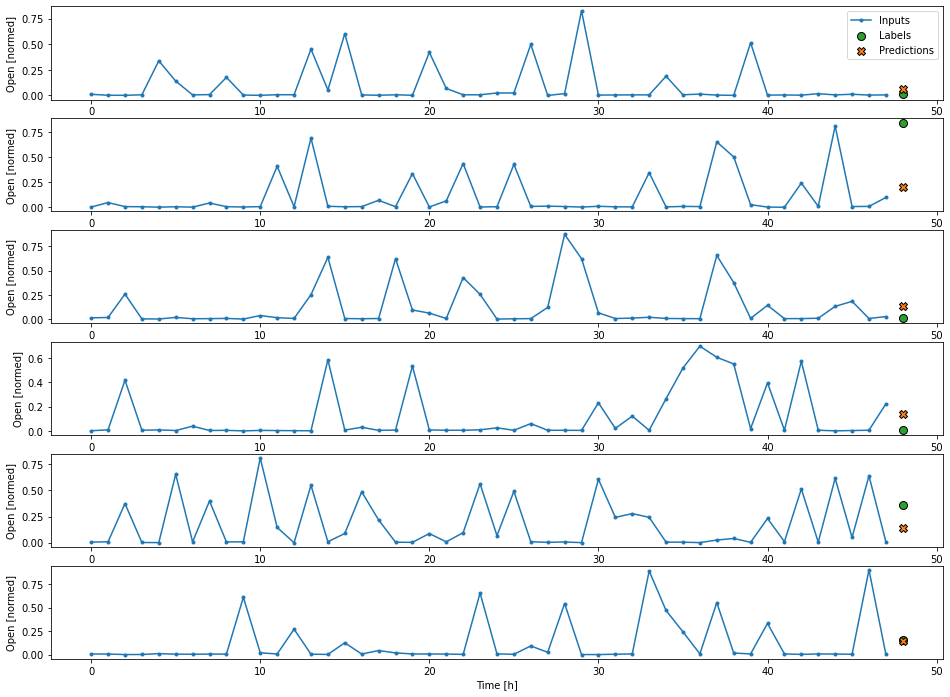

In [292]:
generator.plot(model=model_1, plot_col='Open')

## Many to One relationship

![Many to One Diagram](./images/ManyToOne2.jpg)

Inputs shape (batch, time, features): (256, 5, 5)
Labels shape (batch, time, features): (256, 1, 5)


Text(0.5, 1.0, 'Given 5 days of inputs, predict 1 hour into the future.')

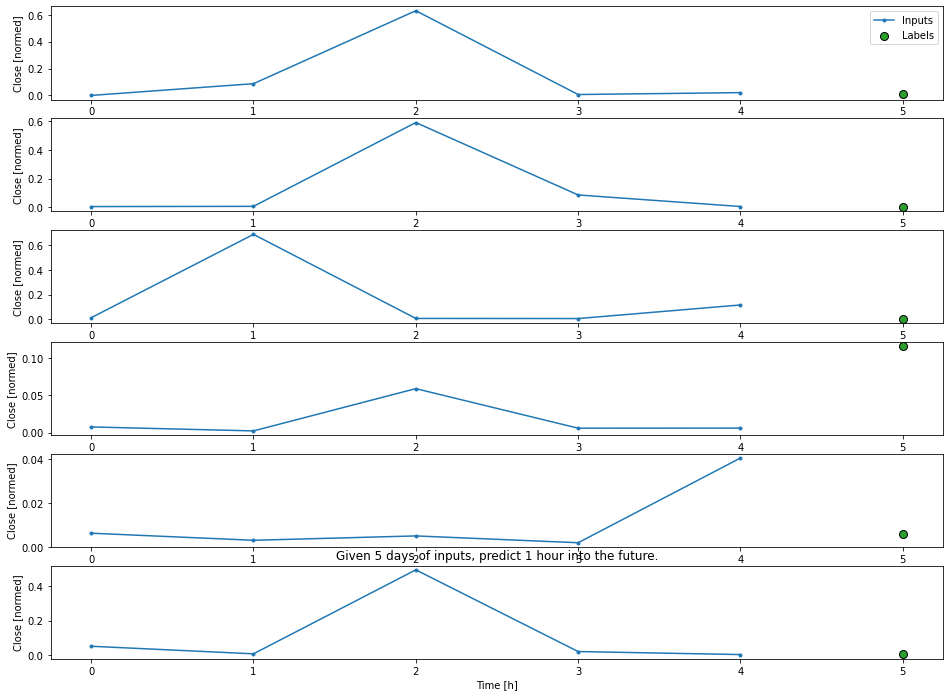

In [259]:
CONV_WIDTH = 5
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Open', 'High', 'Low', 'Close', 'Volume'])

for example_inputs, example_labels in conv_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

conv_window.example = example_inputs, example_labels

conv_window.plot()
plt.title("Given 5 days of inputs, predict 1 hour into the future.")

In [293]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=5),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (256, 5, 5)
Output shape: (256, 1, 5)


In [294]:
history = compile_and_fit(multi_step_dense, conv_window)

Epoch 1/20
20/20 [==============================] - 1s 12ms/step - loss: 0.0405 - mean_absolute_error: 0.1339 - mean_absolute_percentage_error: 2654.2363 - val_loss: 0.0382 - val_mean_absolute_error: 0.1387 - val_mean_absolute_percentage_error: 86639.2109 - lr: 0.0010
Epoch 2/20
20/20 [==============================] - 0s 9ms/step - loss: 0.0382 - mean_absolute_error: 0.1375 - mean_absolute_percentage_error: 3158.9731 - val_loss: 0.0381 - val_mean_absolute_error: 0.1325 - val_mean_absolute_percentage_error: 70899.3203 - lr: 0.0010
Epoch 3/20
20/20 [==============================] - 0s 7ms/step - loss: 0.0381 - mean_absolute_error: 0.1356 - mean_absolute_percentage_error: 3082.4800 - val_loss: 0.0382 - val_mean_absolute_error: 0.1323 - val_mean_absolute_percentage_error: 69920.4062 - lr: 0.0010
Epoch 4/20
20/20 [==============================] - 0s 7ms/step - loss: 0.0379 - mean_absolute_error: 0.1364 - mean_absolute_percentage_error: 3122.4785 - val_loss: 0.0381 - val_mean_absolute_err

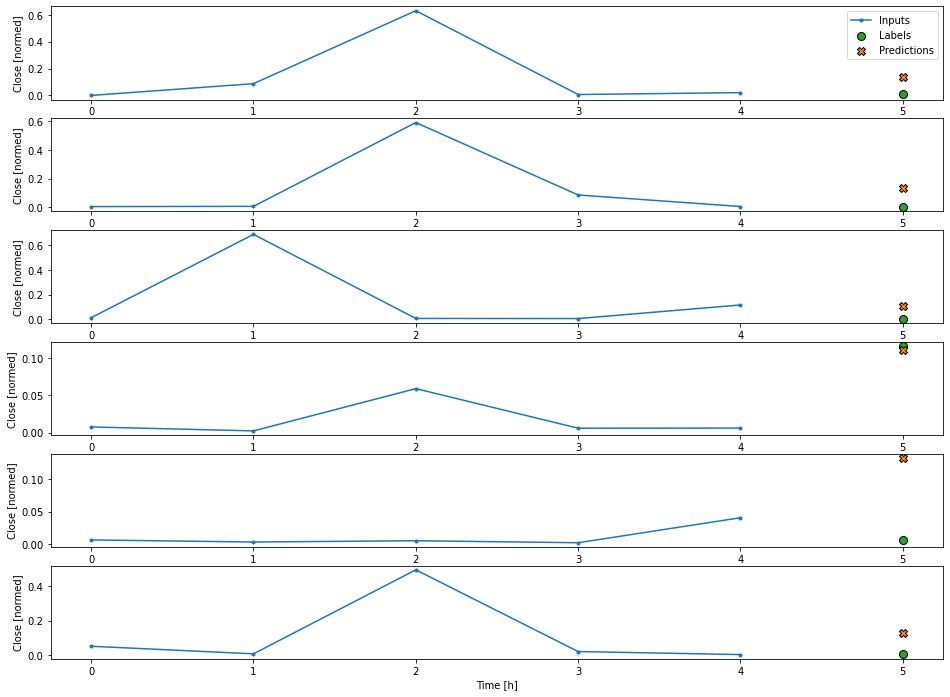

In [295]:
conv_window.plot(multi_step_dense)

In [298]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64*5, kernel_size=CONV_WIDTH, activation='relu'),
    tf.keras.layers.Dense(units=64*5, activation='relu'),
    tf.keras.layers.Dense(units=5),
    tf.keras.layers.Reshape([1, -1]),
])

print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (256, 5, 5)
Output shape: (256, 1, 5)


In [299]:
compile_and_fit(conv_model, conv_window)

Epoch 1/20
20/20 [==============================] - 1s 25ms/step - loss: 0.0408 - mean_absolute_error: 0.1329 - mean_absolute_percentage_error: 2649.3201 - val_loss: 0.0380 - val_mean_absolute_error: 0.1426 - val_mean_absolute_percentage_error: 71644.8281 - lr: 0.0010
Epoch 2/20
20/20 [==============================] - 0s 11ms/step - loss: 0.0382 - mean_absolute_error: 0.1375 - mean_absolute_percentage_error: 3194.0081 - val_loss: 0.0379 - val_mean_absolute_error: 0.1353 - val_mean_absolute_percentage_error: 67783.3125 - lr: 0.0010
Epoch 3/20
20/20 [==============================] - 0s 8ms/step - loss: 0.0380 - mean_absolute_error: 0.1359 - mean_absolute_percentage_error: 3103.4468 - val_loss: 0.0378 - val_mean_absolute_error: 0.1359 - val_mean_absolute_percentage_error: 67488.9766 - lr: 0.0010
Epoch 4/20
20/20 [==============================] - 0s 9ms/step - loss: 0.0379 - mean_absolute_error: 0.1369 - mean_absolute_percentage_error: 3113.2261 - val_loss: 0.0381 - val_mean_absolute_er

In [300]:
conv_model.summary()

Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_42 (Conv1D)          (None, 1, 320)            8320      
                                                                 
 dense_173 (Dense)           (None, 1, 320)            102720    
                                                                 
 dense_174 (Dense)           (None, 1, 5)              1605      
                                                                 
 reshape_58 (Reshape)        (None, 1, 5)              0         
                                                                 
Total params: 112,645
Trainable params: 112,645
Non-trainable params: 0
_________________________________________________________________


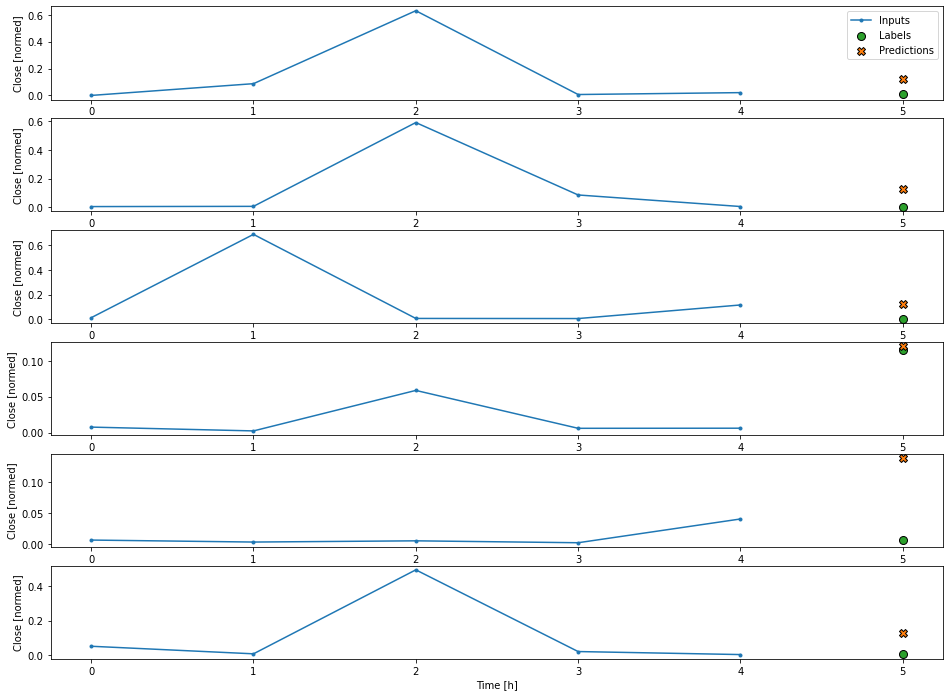

In [301]:
conv_window.plot(conv_model)

### Wider Window

In [302]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Open', 'High', 'Low', 'Close', 'Volume'])

# Add examples
for example_inputs, example_labels in wide_conv_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

wide_conv_window.example = example_inputs, example_labels

wide_conv_window

Inputs shape (batch, time, features): (256, 28, 5)
Labels shape (batch, time, features): (256, 24, 5)


Total window size: 29
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
Label indices: [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28]
Label column name(s): ['Open', 'High', 'Low', 'Close', 'Volume']

In [306]:
conv_model = tf.keras.Sequential([
    # [batch, time, features] => [batch, features, filters]
    tf.keras.layers.Conv1D(filters=LABEL_WIDTH, kernel_size=CONV_WIDTH, activation='relu'),
    tf.keras.layers.Permute([2, 1]),
    tf.keras.layers.Dense(units=2048*5, activation='relu'),
    tf.keras.layers.Dense(units=5, activation='relu'),
    tf.keras.layers.Reshape([LABEL_WIDTH, 5]),
])

compile_and_fit(conv_model, wide_conv_window)

Epoch 1/20
20/20 [==============================] - 1s 21ms/step - loss: 0.0388 - mean_absolute_error: 0.1340 - mean_absolute_percentage_error: 2892.0383 - val_loss: 0.0357 - val_mean_absolute_error: 0.1333 - val_mean_absolute_percentage_error: 61656.2109 - lr: 0.0010
Epoch 2/20
20/20 [==============================] - 0s 15ms/step - loss: 0.0356 - mean_absolute_error: 0.1308 - mean_absolute_percentage_error: 3004.0837 - val_loss: 0.0339 - val_mean_absolute_error: 0.1283 - val_mean_absolute_percentage_error: 58468.3945 - lr: 0.0010
Epoch 3/20
20/20 [==============================] - 0s 15ms/step - loss: 0.0330 - mean_absolute_error: 0.1245 - mean_absolute_percentage_error: 2870.2297 - val_loss: 0.0306 - val_mean_absolute_error: 0.1144 - val_mean_absolute_percentage_error: 40113.4766 - lr: 0.0010
Epoch 4/20
20/20 [==============================] - 0s 16ms/step - loss: 0.0288 - mean_absolute_error: 0.1124 - mean_absolute_percentage_error: 2491.2302 - val_loss: 0.0262 - val_mean_absolute_

In [307]:
conv_model.summary()

Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_44 (Conv1D)          (None, 24, 24)            624       
                                                                 
 permute_9 (Permute)         (None, 24, 24)            0         
                                                                 
 dense_177 (Dense)           (None, 24, 10240)         256000    
                                                                 
 dense_178 (Dense)           (None, 24, 5)             51205     
                                                                 
 reshape_60 (Reshape)        (None, 24, 5)             0         
                                                                 
Total params: 307,829
Trainable params: 307,829
Non-trainable params: 0
_________________________________________________________________


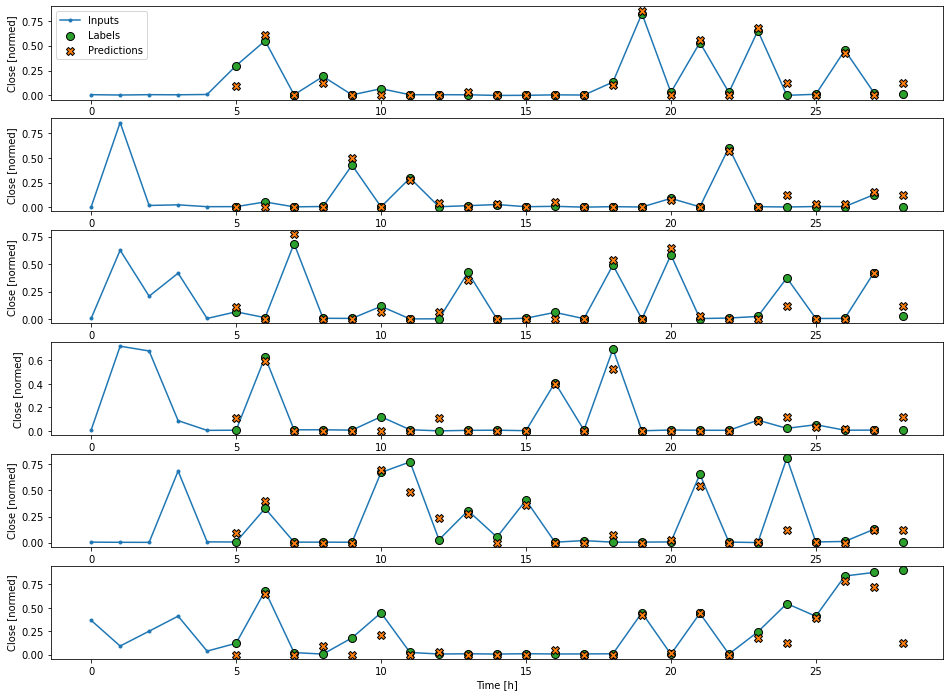

In [308]:
wide_conv_window.plot(conv_model)

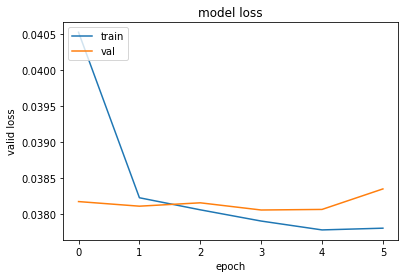

In [309]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('valid loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Multi-Step

![Multi Step Diagram](./images/FuturePredictor.jpg)

Inputs shape (batch, time, features): (256, 24, 5)
Labels shape (batch, time, features): (256, 24, 5)


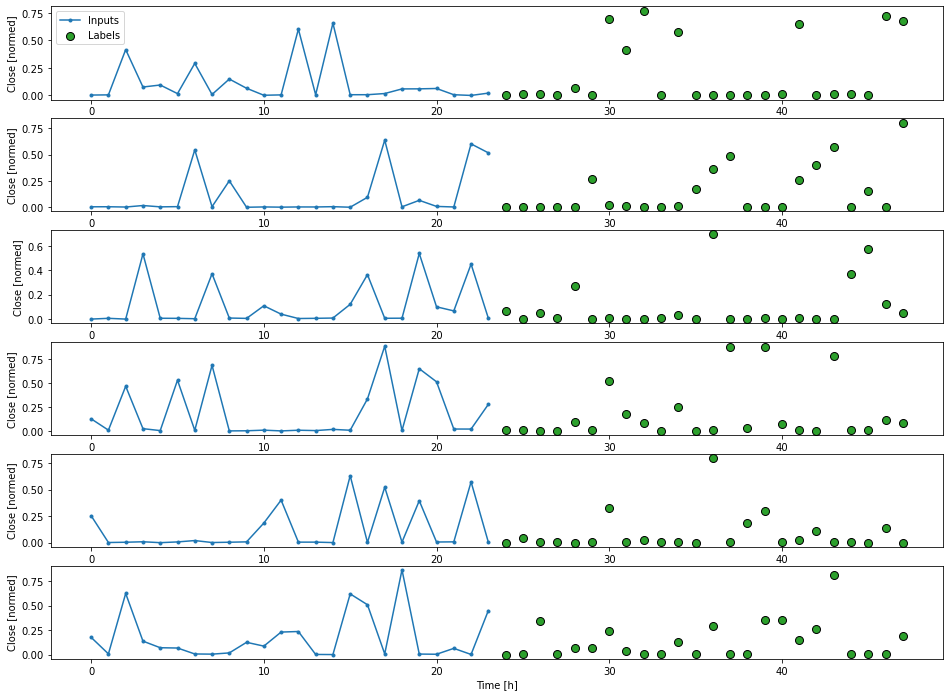

In [318]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

for example_inputs, example_labels in multi_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

multi_window.example = example_inputs, example_labels

multi_window.plot(plot_col='Close')

In [321]:
num_features = 5
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])


history = compile_and_fit(multi_linear_model, multi_window)

Epoch 1/20
20/20 [==============================] - 1s 15ms/step - loss: 0.0446 - mean_absolute_error: 0.1196 - mean_absolute_percentage_error: 1532.4144 - val_loss: 0.0383 - val_mean_absolute_error: 0.1362 - val_mean_absolute_percentage_error: 66618.5312 - lr: 0.0010
Epoch 2/20
20/20 [==============================] - 0s 11ms/step - loss: 0.0384 - mean_absolute_error: 0.1377 - mean_absolute_percentage_error: 3146.6116 - val_loss: 0.0375 - val_mean_absolute_error: 0.1348 - val_mean_absolute_percentage_error: 64354.7812 - lr: 0.0010
Epoch 3/20
20/20 [==============================] - 0s 11ms/step - loss: 0.0381 - mean_absolute_error: 0.1368 - mean_absolute_percentage_error: 3124.8440 - val_loss: 0.0373 - val_mean_absolute_error: 0.1339 - val_mean_absolute_percentage_error: 63605.2617 - lr: 0.0010
Epoch 4/20
20/20 [==============================] - 0s 10ms/step - loss: 0.0380 - mean_absolute_error: 0.1366 - mean_absolute_percentage_error: 3115.4917 - val_loss: 0.0372 - val_mean_absolute_

In [322]:
multi_linear_model.summary()

Model: "sequential_87"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_3 (Lambda)           (None, 1, 5)              0         
                                                                 
 dense_185 (Dense)           (None, 1, 512)            3072      
                                                                 
 dense_186 (Dense)           (None, 1, 120)            61560     
                                                                 
 reshape_64 (Reshape)        (None, 24, 5)             0         
                                                                 
Total params: 64,632
Trainable params: 64,632
Non-trainable params: 0
_________________________________________________________________


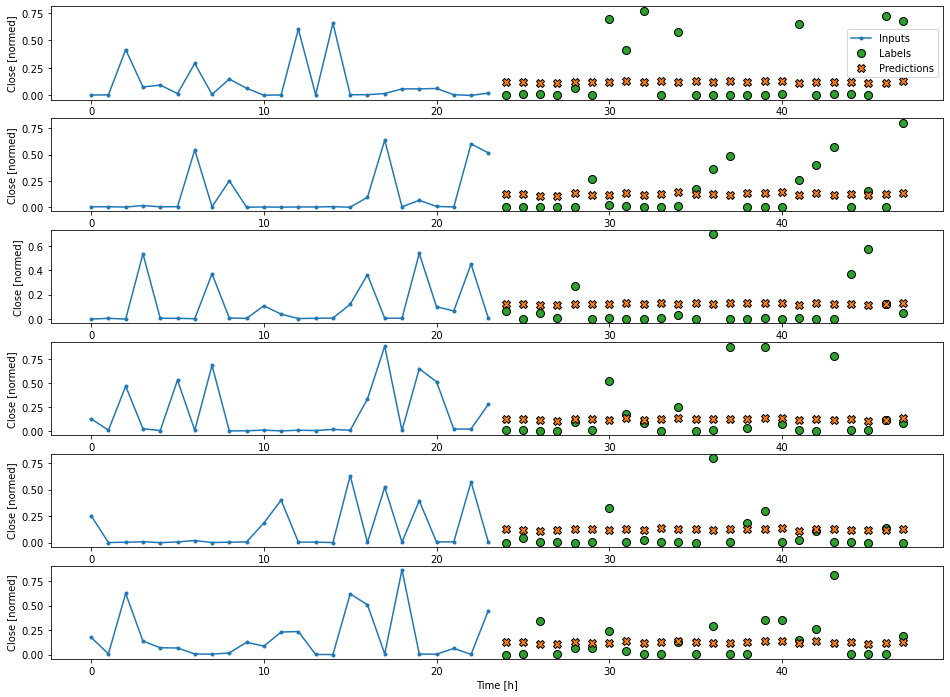

In [323]:
multi_window.plot(model=multi_linear_model, )

In [334]:
CONV_WIDTH = 24
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(1024, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

Epoch 1/20
20/20 [==============================] - 1s 12ms/step - loss: 0.0414 - mean_absolute_error: 0.1313 - mean_absolute_percentage_error: 2456.1250 - val_loss: 0.0383 - val_mean_absolute_error: 0.1403 - val_mean_absolute_percentage_error: 66793.6250 - lr: 0.0010
Epoch 2/20
20/20 [==============================] - 0s 7ms/step - loss: 0.0385 - mean_absolute_error: 0.1344 - mean_absolute_percentage_error: 2967.3389 - val_loss: 0.0374 - val_mean_absolute_error: 0.1337 - val_mean_absolute_percentage_error: 59906.0391 - lr: 0.0010
Epoch 3/20
20/20 [==============================] - 0s 7ms/step - loss: 0.0380 - mean_absolute_error: 0.1361 - mean_absolute_percentage_error: 3099.8594 - val_loss: 0.0373 - val_mean_absolute_error: 0.1353 - val_mean_absolute_percentage_error: 58948.1016 - lr: 0.0010
Epoch 4/20
20/20 [==============================] - 0s 7ms/step - loss: 0.0379 - mean_absolute_error: 0.1359 - mean_absolute_percentage_error: 3088.3010 - val_loss: 0.0375 - val_mean_absolute_err

In [335]:
multi_conv_model.summary()

Model: "sequential_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_8 (Lambda)           (None, 24, 5)             0         
                                                                 
 conv1d_48 (Conv1D)          (None, 1, 1024)           123904    
                                                                 
 dense_192 (Dense)           (None, 1, 120)            123000    
                                                                 
 reshape_69 (Reshape)        (None, 24, 5)             0         
                                                                 
Total params: 246,904
Trainable params: 246,904
Non-trainable params: 0
_________________________________________________________________


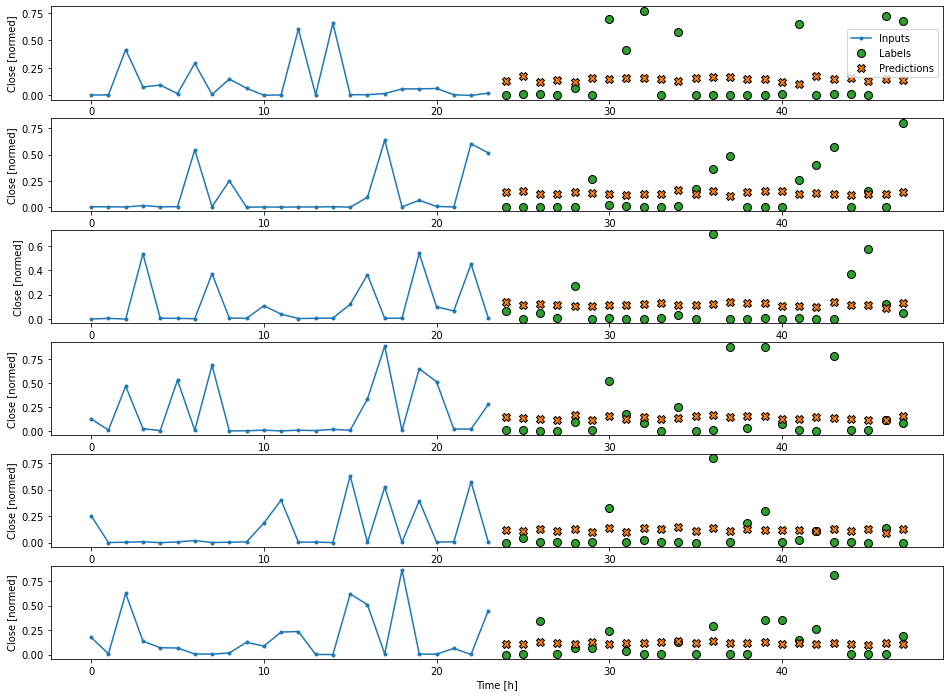

In [336]:
multi_window.plot(model=multi_conv_model, )

In [345]:
wide_window = WindowGenerator(input_width=48,
                                label_width=48,
                                shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

wide_window.example = example_inputs, example_labels

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(256, return_sequences=True, use_bias=True, stateful=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(5)
])

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

compile_and_fit(lstm_model, wide_window, patience=5)

Inputs shape (batch, time, features): (256, 48, 5)
Labels shape (batch, time, features): (256, 48, 5)
Input shape: (256, 48, 5)
Output shape: (256, 48, 5)
Epoch 1/20
19/20 [===========================>..] - ETA: 0s - loss: 0.0407 - mean_absolute_error: 0.1320 - mean_absolute_percentage_error: 2602.7864

InvalidArgumentError:    Invalid input_h shape: [1,256,256] [1,106,256]
	 [[{{node CudnnRNN}}]]
	 [[sequential_99/lstm_16/PartitionedCall]] [Op:__inference_train_function_370915]

Function call stack:
train_function -> train_function -> train_function


In [ ]:
lstm_model.summary()

Model: "sequential_94"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 24, 1024)          4218880   
                                                                 
 dense_194 (Dense)           (None, 24, 5)             5125      
                                                                 
Total params: 4,224,005
Trainable params: 4,224,005
Non-trainable params: 0
_________________________________________________________________


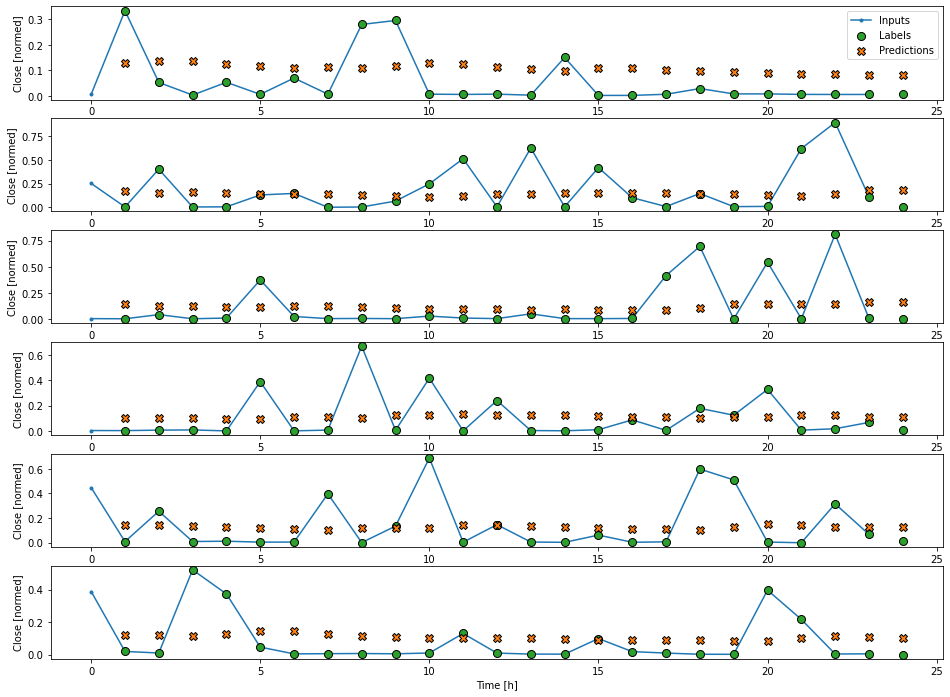

In [341]:
wide_window.plot(model=lstm_model)

# Extra Code Snippets

In [28]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10) # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.0000001)

callbacks = [earlystop, learning_rate_reduction]